<a href="https://colab.research.google.com/github/andreasalvucci/ka-morra/blob/main/convnet_using_tensorflow_for_beginners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
* Build and train a Convolutional Neural Network in TensorFlow for a multiclass classification problem of counting fingers using Functional API

In [1]:
! pip install -r ./requirements.txt

import opendatasets as od
od.download("https://www.kaggle.com/datasets/koryakinp/fingers")

Skipping, found downloaded files in ".\fingers" (use force=True to force download)


In [2]:
from tqdm.notebook import tqdm

In [3]:
#  import libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers as tfl
import os
import cv2
from sklearn import preprocessing
from pathlib import Path
from PIL import Image


# Data Preprocessing

The input images are present in the  "train" and "test" folders. 
* Iterate through each folder seperately and store image paths in separate lists 'train_set_path' and 'test_set_path'
* Extract y labels for train and test sets seperately in two lists 'train_set_label' and 'test_set_label' by splitting the filename and collecting the two literals before the dot.
Ex: /input/fingers/test/ef512789-23fb-4da6-ad2e-38780d9cd914_**1L**.png

In [4]:
#function to extract y labels from base file path
def extract_label(base):
    path = []
    label = []
    for filename in os.listdir(base):
        label.append(filename.split('.')[0][-2:]) #split on dot and read the preceding 2 literals
        path.append(base+filename)
    return path, label

In [5]:
#base file paths for train and test folders
train_base = "./fingers/train/"
test_base = "./fingers/test/"

#list variables holding file paths and y labels for train and test sets
train_set_path, train_set_label = extract_label(train_base)
test_set_path, test_set_label = extract_label(test_base)

print("Number of training set examples: ", len(train_set_path))
print("Number of test set examples: ", len(test_set_path))

Number of training set examples:  18000
Number of test set examples:  3600


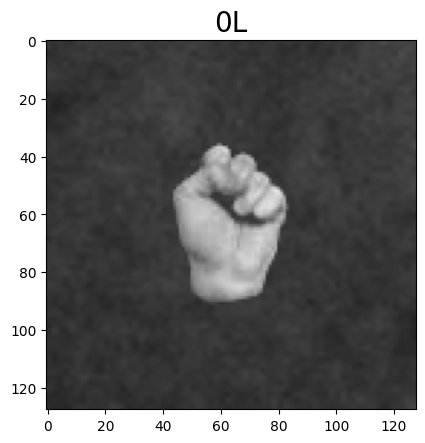

In [6]:
# Read first image in the training set using opencv api
index=0
image = cv2.imread(train_set_path[index]) 

# display image
plt.imshow(image)
plt.title(train_set_label[index], fontsize = 20)
plt.show()

# Feature Data Train/Test Split

Feature data is split into X_train and X_test by reading images from train and test folders and storing them in lists

In [7]:
# function to split feature data into train and test 
def feature_data_split(path):
    feature_set = []
    for p in tqdm(path):
        image = cv2.imread(p)
        feature_set.append(image)
    return feature_set

In [8]:
# read images for train and test set
X_train = feature_data_split(train_set_path)
X_test = feature_data_split(test_set_path)

# convert lists into np arrays to facilitate modelling
X_train = np.array(X_train)
X_test = np.array(X_test)

# check shapes
print(X_train.shape)
print(X_test.shape)

  0%|          | 0/18000 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

(18000, 128, 128, 3)
(3600, 128, 128, 3)


The shapes of X_train and X_test are in expected format i.e, (no of examples, height, width, no of channels)

# Label Data Train/Test Split

The label set has two literal values. ConvNet needs them to be one-hot encoded for modelling. 
* Use Label Encoder from scikit learn to convert labels into unique int values
* Use Keras to one-hot encode the unique values and create a binary matrix representation of y label sets

In [9]:
# check unique values in train and test sets
print("Train Label set unique values: ", list(np.unique(train_set_label)))
print("Test  Label set unique values: ", list(np.unique(test_set_label)))
if len(np.unique(train_set_label)) == len(np.unique(test_set_label)):
  print("Number of unique classes: ", len(np.unique(train_set_label)))
  num_classes = len(np.unique(train_set_label))

Train Label set unique values:  ['0L', '0R', '1L', '1R', '2L', '2R', '3L', '3R', '4L', '4R', '5L', '5R']
Test  Label set unique values:  ['0L', '0R', '1L', '1R', '2L', '2R', '3L', '3R', '4L', '4R', '5L', '5R']
Number of unique classes:  12


In [10]:
# apply label encoder to the y train and test sets
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(train_set_label)
y_test = label_encoder.fit_transform(test_set_label)

print("Label Encoded Train Label set unique values: ", np.unique(y_train))
print("Label Encoded Test  Label set unique values: ", np.unique(y_test))
if len(np.unique(y_train)) == len(np.unique(y_test)):
  print("Number of unique classes: ", len(np.unique(y_train)))
  num_classes = len(np.unique(y_train))

Label Encoded Train Label set unique values:  [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label Encoded Test  Label set unique values:  [ 0  1  2  3  4  5  6  7  8  9 10 11]
Number of unique classes:  12


In [11]:
# one hot encode y label train and test sets
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(y_train.shape)
print(y_test.shape)

(18000, 12)
(3600, 12)


# ConvNet Model Definition, Compilation and Training

The ConvNet will be defined as follows:
* CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE

Parameters used-
* Conv2D: Use 8 4 by 4 filters, stride 1, padding is "SAME"
* Activatin function  'ReLU'
* MaxPool2D: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
* Conv2D: Use 16 2 by 2 filters, stride 1, padding is "SAME"
* Activatin function  'ReLU'
* MaxPool2D: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
* Flatten the previous output
* Fully-connected (Dense) layer: Apply a fully connected layer with "num_classes" neurons and a softmax activation for multi-class classification output

In [12]:
def convolutional_model(input_shape):
    input_img = tf.keras.Input(shape=input_shape)
    conv_layer1 = tfl.Conv2D(filters= 8 , kernel_size= 4 , strides= 1 , padding='same')(input_img)
    activation1 = tfl.ReLU()(conv_layer1)
    pool_layer1 = tfl.MaxPool2D(pool_size=8, strides=8, padding='same')(activation1)
    conv_layer2 = tfl.Conv2D(filters= 16 , kernel_size= 2 , strides= 1 , padding='same')(pool_layer1)
    activation2 = tfl.ReLU()(conv_layer2)
    pool_layer2 = tfl.MaxPool2D(pool_size=4, strides=4, padding='same')(activation2)
    flatten =  tfl.Flatten()(pool_layer2)
    outputs =  tfl.Dense(units=num_classes, activation='softmax')(flatten)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [13]:
# Compile ConvNet model
conv_model = convolutional_model((128, 128, 3))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 8)       392       
                                                                 
 re_lu (ReLU)                (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        528       
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 16)        0         
                                                             

In [14]:
# train ConvNet Model
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(128)

history = conv_model.fit(train_dataset, epochs=5, validation_data=test_dataset)

Epoch 1/5
141/141 [==============================] - 41s 286ms/step - loss: 7.9168 - accuracy: 0.4399 - val_loss: 0.8395 - val_accuracy: 0.7439
Epoch 2/5
141/141 [==============================] - 38s 273ms/step - loss: 0.4460 - accuracy: 0.8614 - val_loss: 0.2546 - val_accuracy: 0.9178
Epoch 3/5
141/141 [==============================] - 38s 272ms/step - loss: 0.1827 - accuracy: 0.9397 - val_loss: 0.1574 - val_accuracy: 0.9472
Epoch 4/5
141/141 [==============================] - 38s 272ms/step - loss: 0.1116 - accuracy: 0.9623 - val_loss: 0.1081 - val_accuracy: 0.9650
Epoch 5/5
141/141 [==============================] - 39s 274ms/step - loss: 0.0743 - accuracy: 0.9755 - val_loss: 0.0831 - val_accuracy: 0.9722


In [15]:
#conv_model.save("conv_model.h5")
#conv_model = keras.models.load_model("conv_model.h5")

# Model Evaluation

In [16]:
conv_model.evaluate(X_test, y_test)

113/113 [==============================] - 3s 26ms/step - loss: 0.0831 - accuracy: 0.9722


[0.08306754380464554, 0.9722222089767456]

C:\Users\andre\AppData\Local\Temp\ipykernel_16736\2726032185.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_16736\2726032185.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

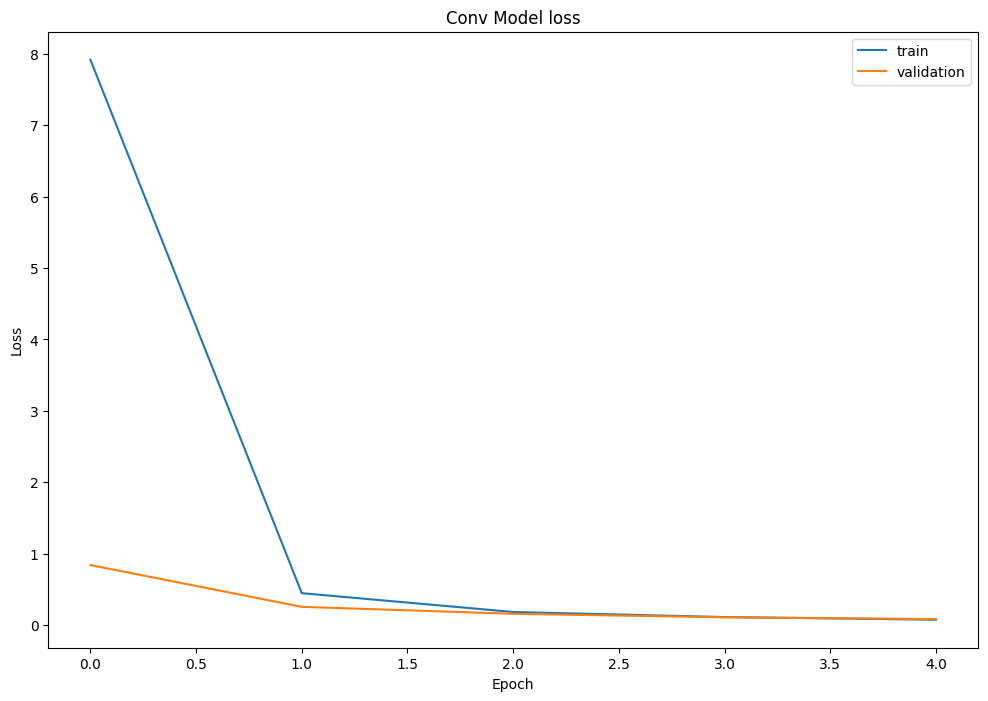

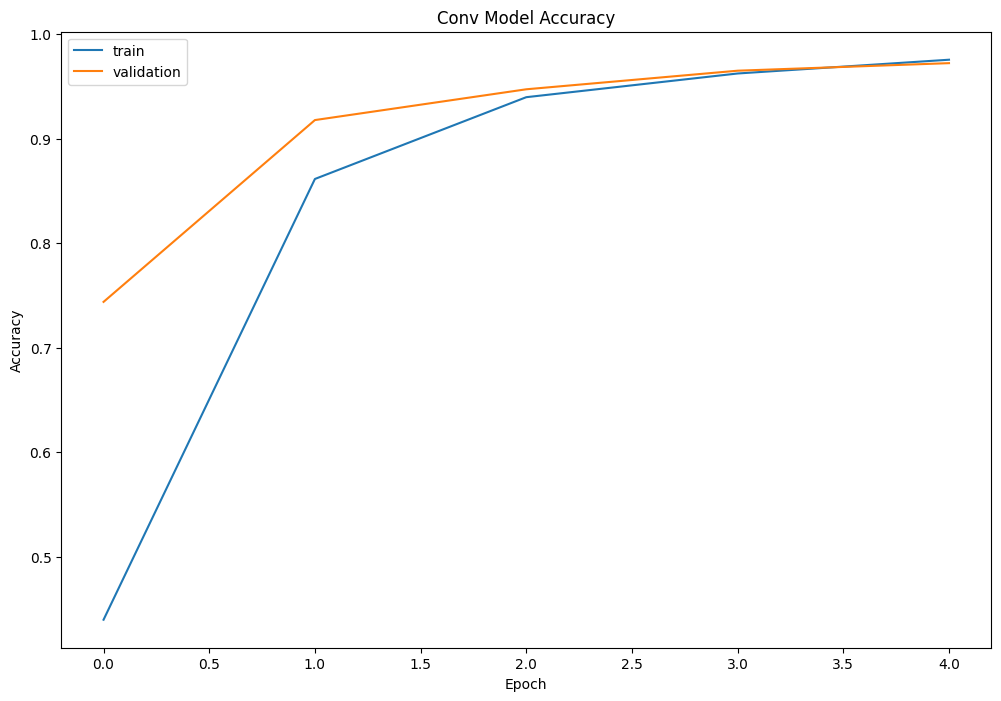

In [17]:
# plot graphs comparing model loss and accuracy against the number of epochs 
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Conv Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Conv Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

As we can see, as the number of epochs increase, the loss decreases and the accuracy of the model increases

4/4 [==============================] - 0s 23ms/step


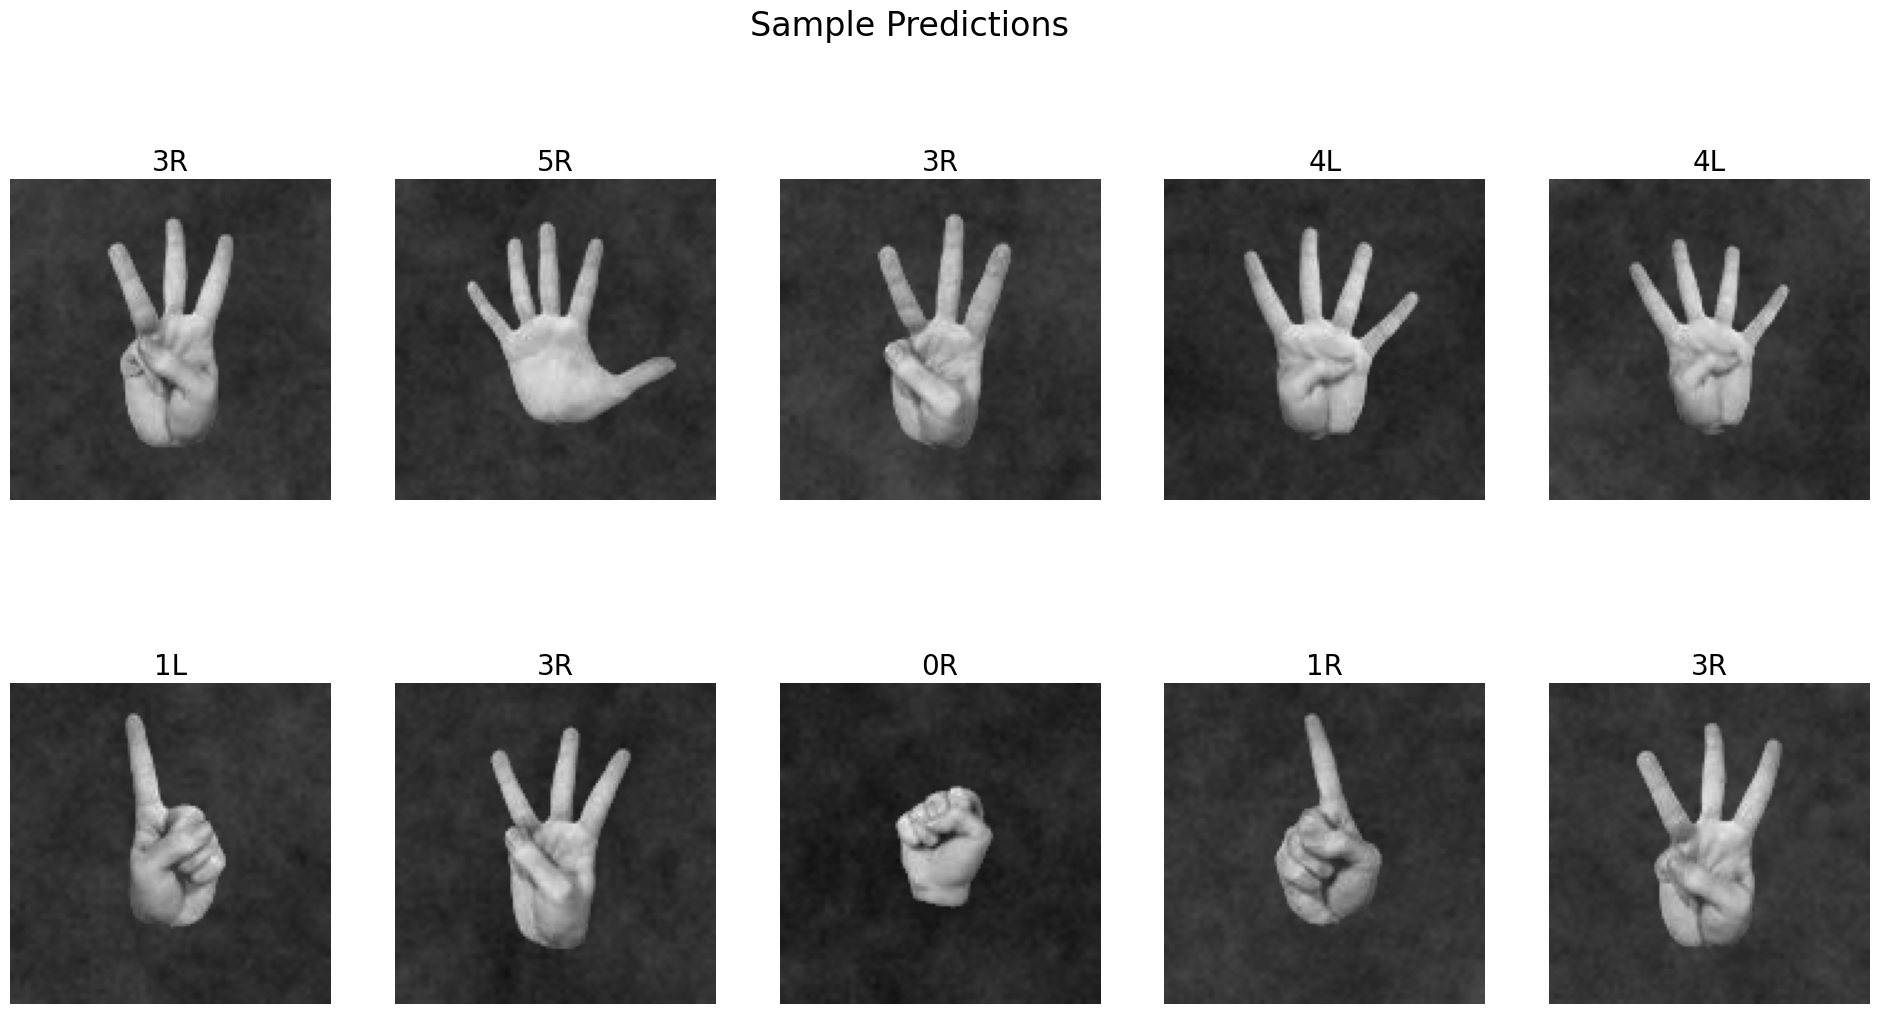

In [18]:
sample_predictions = conv_model.predict(X_test[:100])
sample_predictions[10:20]
fig, axs= plt.subplots(2,5, figsize=[24,12])


count=20
for i in range(2):    
    for j in range(5):  
        
        img = cv2.imread(test_set_path[count])
        results = np.argsort(sample_predictions[count])[::-1]
        labels = label_encoder.inverse_transform(results) # get the label names using inverse transform
        axs[i][j].imshow(img)
        axs[i][j].set_title(labels[0], fontsize = 20)
        axs[i][j].axis('off')

        count+=1
        
plt.suptitle("Sample Predictions", fontsize = 24)        
plt.show()

# > Thank you for your valuable time!

In [72]:
def remove_bg(imgo):
    height, width = imgo.shape[:2]
        #Create a mask holder
    mask = np.zeros(imgo.shape[:2],np.uint8)
    #Grab Cut the object
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    #Hard Coding the Rect The object must lie within this rect.
    rect = (10,10,width-30,height-30)
    cv2.grabCut(imgo,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img1 = imgo*mask[:,:,np.newaxis]

    #Get the background
    background = imgo - img1 

    #Change all pixels in the background that are not black to white
    background[np.where((background > [0,0,0]).all(axis = 2))] = [255,255,255]
    background_noisy = background + gaussian

    #Add the background and the image
    final = background + img1

    return final

In [20]:
def automatic_brightness_and_contrast(image, clip_hist_percent=25):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return auto_result

In [73]:
path_1 = './new-tests/1.jpg'
path_3 = './new-tests/3-2.jpg'
path_4 = './new-tests/4.jpg'

new_image = cv2.imread(path_4)

resized_image = cv2.resize(new_image, (128,128))

image_to_test = remove_bg(resized_image)
image_to_test = np.bitwise_not(image_to_test)
image_to_test = cv2.cvtColor(image_to_test, cv2.COLOR_BGR2GRAY)
image_to_test = cv2.cvtColor(image_to_test, cv2.COLOR_GRAY2BGR)
image_to_test = automatic_brightness_and_contrast(image_to_test,5)

cv2.imwrite("./to_test.jpg",image_to_test)


labels_dict = ['0L','0R','1L','1R','2L','2R', '3L', '3R','4L','4R','5L','5R']

#prediction = conv_model.predict(image_to_test)
prediction = conv_model.predict(image_to_test.reshape(1,128,128,3))
print(labels_dict[np.argmax(prediction)])

error: OpenCV(4.6.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0xd2168eb3::Set<1,-1,-1>,struct cv::impl::A0xd2168eb3::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 4 (CV_32S)
